## scANVI analysis for healthy PBMC pilot study (Cai 2020 and Cai 2022)

**Objective**: Run scANVI analysis for label transfer for healthy PBMCs [Cai 2020 and Cai 2022]


- **Developed by**: Mairi McClean

- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**

- v230317

- Following this tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html
> "This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query)."



### Import modules 

In [1]:
import sys

from scvi_colab import install

install()

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install --quiet scrublet

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import sys
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi


Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 94705


### Read in and prepare data
- Following steps from scVI portion of tutorial

In [4]:
adata_ref = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/INBOX/sc_downloads/yoshida_2021/meyer_nikolic_covid_pbmc.cellxgene.20210813.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 422220 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [5]:
adata_ref.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,Sex,Smoker,sample_id,sequencing_library,Protein_modality_weight
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.359517
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.577522
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,Male,Non-smoker,AN3,CV001_KM10202384-CV001_KM10202394,0.369143
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.785563
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,Female,Non-smoker,AN5,CV001_KM10202384-CV001_KM10202394,0.564174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S28_TTTGTCAGTTCTGTTT-1,PC9,EUR,27.17,NK,NK,NK,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.429398
S28_TTTGTCATCAACCAAC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.677910
S28_TTTGTCATCATTATCC-1,PC9,EUR,27.17,Monocyte,Monocyte CD14,Classical monocyte,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.422796
S28_TTTGTCATCCTATGTT-1,PC9,EUR,27.17,DC,pDC,pDC,Adult,Severe,Post-COVID-19,Adult,Male,Non-smoker,PC9,CV001_KM9294396-CV001_KM9294404,0.471905


- Filter query dataset to online include healthy cells

In [6]:
adata_ref.obs['COVID_status'].value_counts()

Healthy          173684
COVID-19         151312
Post-COVID-19     97224
Name: COVID_status, dtype: int64

In [7]:
adata_ref_new = adata_ref[~adata_ref.obs['COVID_status'].isin(['COVID-19', 'Post-COVID-19']),:]
adata_ref_new

View of AnnData object with n_obs × n_vars = 173684 × 33751
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'
    obsm: 'X_ umap (wnn derived)', 'X_umap (after harmony ADT)', 'X_umap (after harmony RNA)', 'X_umap (before harmony ADT)', 'X_umap (before harmony RNA)'

In [8]:
adata_ref_new.obs['COVID_status'].value_counts()

Healthy    173684
Name: COVID_status, dtype: int64

- Read in query data

In [9]:
# Note: Query data is that of only Cai, not the Cai+Yoshida data, but clustered following scvi. This is not the correct data object?

# adata_query = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/scvi/post_sccaf/CaiY_healthy_scRNA_PBMC_mm230316_scVI-clustered.raw.h5ad')

adata_query_2020 = sc.read_h5ad('/Volumes/LaCie/data_lake/Mairi_example/processed_files/abridged_qc/human/CaiY2020_PBMC_mm230306.h5ad')
adata_query_2020

In [ ]:
adata_query_2022 = sc.read_h5ad('/Volumes/LaCie/data_lake/Mairi_example/processed_files/abridged_qc/human/CaiY2022_PBMC_mm230307.h5ad')
adata_query_2022

- Concatenate both query datasets


In [ ]:
adata_query = adata_query_2020.concatenate(adata_query_2022, join='inner', batch_categories=['2020', '2022'], batch_key='year')

- Concatenate anndata objects

In [11]:
adata_healthy = adata_ref_new.concatenate(adata_query, join="inner", batch_categories=['reference', 'query'], batch_key='dataset')

In [12]:
adata_healthy

AnnData object with n_obs × n_vars = 195733 × 22792
    obs: 'patient_id', 'Ethnicity', 'BMI', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'Age_group', 'COVID_severity', 'COVID_status', 'Group', 'Sex', 'Smoker', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-caiy2020-query', 'mean_counts-caiy2020-query', 'pct_dropout_by_counts-caiy2020-query', 'total_counts-caiy2020-query', 'n_cells_by_counts-caiy2022-query', 'mean_counts-caiy2022-query', 'pct_dropout_by_

In [80]:
adata_healthy.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,...,XIST-counts,S_score,G2M_score,predicted_doublets,object,protocol,dataset,_scvi_batch,_scvi_labels,leiden
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1-reference,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1-reference,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1-reference,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1-reference,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1-reference,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCGCGGTT-H1-caiy2020-query,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.165353,-0.250572,0.0,NaN,NaN,query,0.0,0.0,0
TTTGTCAGTCGCTTCT-H1-caiy2020-query,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.177318,-0.173327,0.0,NaN,NaN,query,0.0,0.0,0
TTTGTCAGTTCGAATC-H1-caiy2020-query,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.235875,-0.013744,0.0,NaN,NaN,query,0.0,0.0,1
TTTGTCAGTTTGGGCC-H1-caiy2020-query,NaN,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.050351,0.022269,0.0,NaN,NaN,query,0.0,0.0,0


In [81]:
print(adata_healthy.obs.dtypes)

patient_id                       category
Ethnicity                        category
BMI                              category
annotation_broad                 category
annotation_detailed              category
annotation_detailed_fullNames    category
Age_group                        category
COVID_severity                   category
COVID_status                     category
Group                            category
Sex                              category
Smoker                           category
sample_id                        category
sequencing_library               category
Protein_modality_weight           float64
study                            category
individual                       category
sample                           category
tissue                           category
donor                            category
age                              category
gender                           category
status                           category
data_type                        c

In [42]:
adata_healthy.obs['annotation_broad'].value_counts()

T CD4+       49415
T CD8+       34110
Monocyte     28637
B            26132
NK           21871
T reg         3251
T g/d         3183
MAIT          2213
DC            2151
Cycling       1012
Platelets      626
HPC            416
Plasma         352
ILC            199
RBC            106
Baso/Eos        10
Name: annotation_broad, dtype: int64

In [ ]:
adata_healthy.obs["annotation_detailed"] = adata_healthy.obs["annotation_detailed"].cat.add_categories("unknown").fillna("unknown")


In [87]:
adata_healthy.obs["annotation_detailed_fullNames"] = adata_healthy.obs["annotation_detailed_fullNames"].cat.add_categories("unknown").fillna("unknown")


In [88]:
adata_healthy.obs

,patient_id,Ethnicity,BMI,annotation_broad,annotation_detailed,annotation_detailed_fullNames,Age_group,COVID_severity,COVID_status,Group,...,XIST-counts,S_score,G2M_score,predicted_doublets,object,protocol,dataset,_scvi_batch,_scvi_labels,leiden
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1-reference,AN5,EUR,Unknown,Monocyte,Monocyte CD14,Classical monocyte,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1-reference,AN5,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1-reference,AN3,EUR,Unknown,T CD4+,T CD4 helper,T CD4 helper,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1-reference,AN5,EUR,Unknown,T CD8+,T CD8 naive,T CD8 naive,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1-reference,AN5,EUR,Unknown,T CD4+,T CD4 naive,T CD4 naive,Adult,Healthy,Healthy,Adult,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCGCGGTT-H1-caiy2020-query,NaN,NaN,NaN,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,0.0,-0.165353,-0.250572,0.0,NaN,NaN,query,0.0,0.0,0
TTTGTCAGTCGCTTCT-H1-caiy2020-query,NaN,NaN,NaN,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,0.0,-0.177318,-0.173327,0.0,NaN,NaN,query,0.0,0.0,0
TTTGTCAGTTCGAATC-H1-caiy2020-query,NaN,NaN,NaN,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,0.0,-0.235875,-0.013744,0.0,NaN,NaN,query,0.0,0.0,1
TTTGTCAGTTTGGGCC-H1-caiy2020-query,NaN,NaN,NaN,unknown,unknown,unknown,NaN,NaN,NaN,NaN,...,0.0,-0.050351,0.022269,0.0,NaN,NaN,query,0.0,0.0,0


- Rename cell type labels column

In [89]:
adata_healthy.obs["labels_scanvi"] = adata_healthy.obs["annotation_broad"].values

In [92]:
adata_healthy.obs['labels_scanvi'].value_counts()

T CD4+       49415
T CD8+       34110
Monocyte     28637
B            26132
unknown      22049
NK           21871
T reg         3251
T g/d         3183
MAIT          2213
DC            2151
Cycling       1012
Platelets      626
HPC            416
Plasma         352
ILC            199
RBC            106
Baso/Eos        10
Name: labels_scanvi, dtype: int64

- Set labels for anndata obs
> Taken from Anna's notebook

In [93]:
condition_key = 'dataset'
cell_type_key = 'labels_scanvi'
target_conditions = ['query']

- Filter genes

In [95]:
# Save counts in layer

adata_healthy.layers['counts'] = adata_healthy.X.copy()

In [96]:
# Note: For best practices of how/when to perform feature selection, 
# please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

sc.pp.highly_variable_genes(
    adata_healthy,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="dataset",
)

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


### Train reference

> From tutorial: SCANVI tends to perform better in situations where it has been initialized using a pre-trained SCVI model. 

Reference anndata must be processed in the same way as the query object (in the previous step). E.g. HVG, and saving the counts layer


- scVI model

In [15]:
scvi.model.SCVI.setup_anndata(adata_ref_new, batch_key="sequencing_library", layer="counts")

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [14]:
# Added for sarches params following tutorial; check if we require it?
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

scvi_ref_new_model = scvi.model.SCVI(adata_ref_new, **arches_params)
scvi_ref_new_model.train()

- scANVI model

In [18]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scanvi = scvi.model.SCANVI.from_scvi_model(
    scvi_ref_new_model,
    unlabeled_category="Unknown",
    labels_key="labels_scanvi",
)

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:172: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/_utils.py:172: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [19]:
vae_ref_scanvi.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/10:  10%|█         | 1/10 [01:44<15:38, 104.29s/it, loss=522, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/10:  20%|██        | 2/10 [03:32<14:14, 106.84s/it, loss=517, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/10:  30%|███       | 3/10 [05:26<12:49, 109.96s/it, loss=513, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/10:  40%|████      | 4/10 [07:18<11:04, 110.67s/it, loss=518, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/10:  50%|█████     | 5/10 [09:08<09:12, 110.51s/it, loss=511, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/10:  60%|██████    | 6/10 [10:58<07:21, 110.36s/it, loss=513, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/10:  70%|███████   | 7/10 [12:49<05:31, 110.62s/it, loss=513, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/10:  80%|████████  | 8/10 [14:40<03:41, 110.63s/it, loss=515, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10:  90%|█████████ | 9/10 [16:34<01:51, 111.65s/it, loss=514, v_num=1]

/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10: 100%|██████████| 10/10 [18:26<00:00, 111.96s/it, loss=514, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [18:26<00:00, 110.70s/it, loss=514, v_num=1]


In [20]:
adata_ref_new.obsm["X_scANVI"] = vae_ref_scanvi.get_latent_representation()
sc.pp.neighbors(adata_ref_new, use_rep="X_scANVI")
sc.tl.leiden(adata_ref_new)
sc.tl.umap(adata_ref_new)


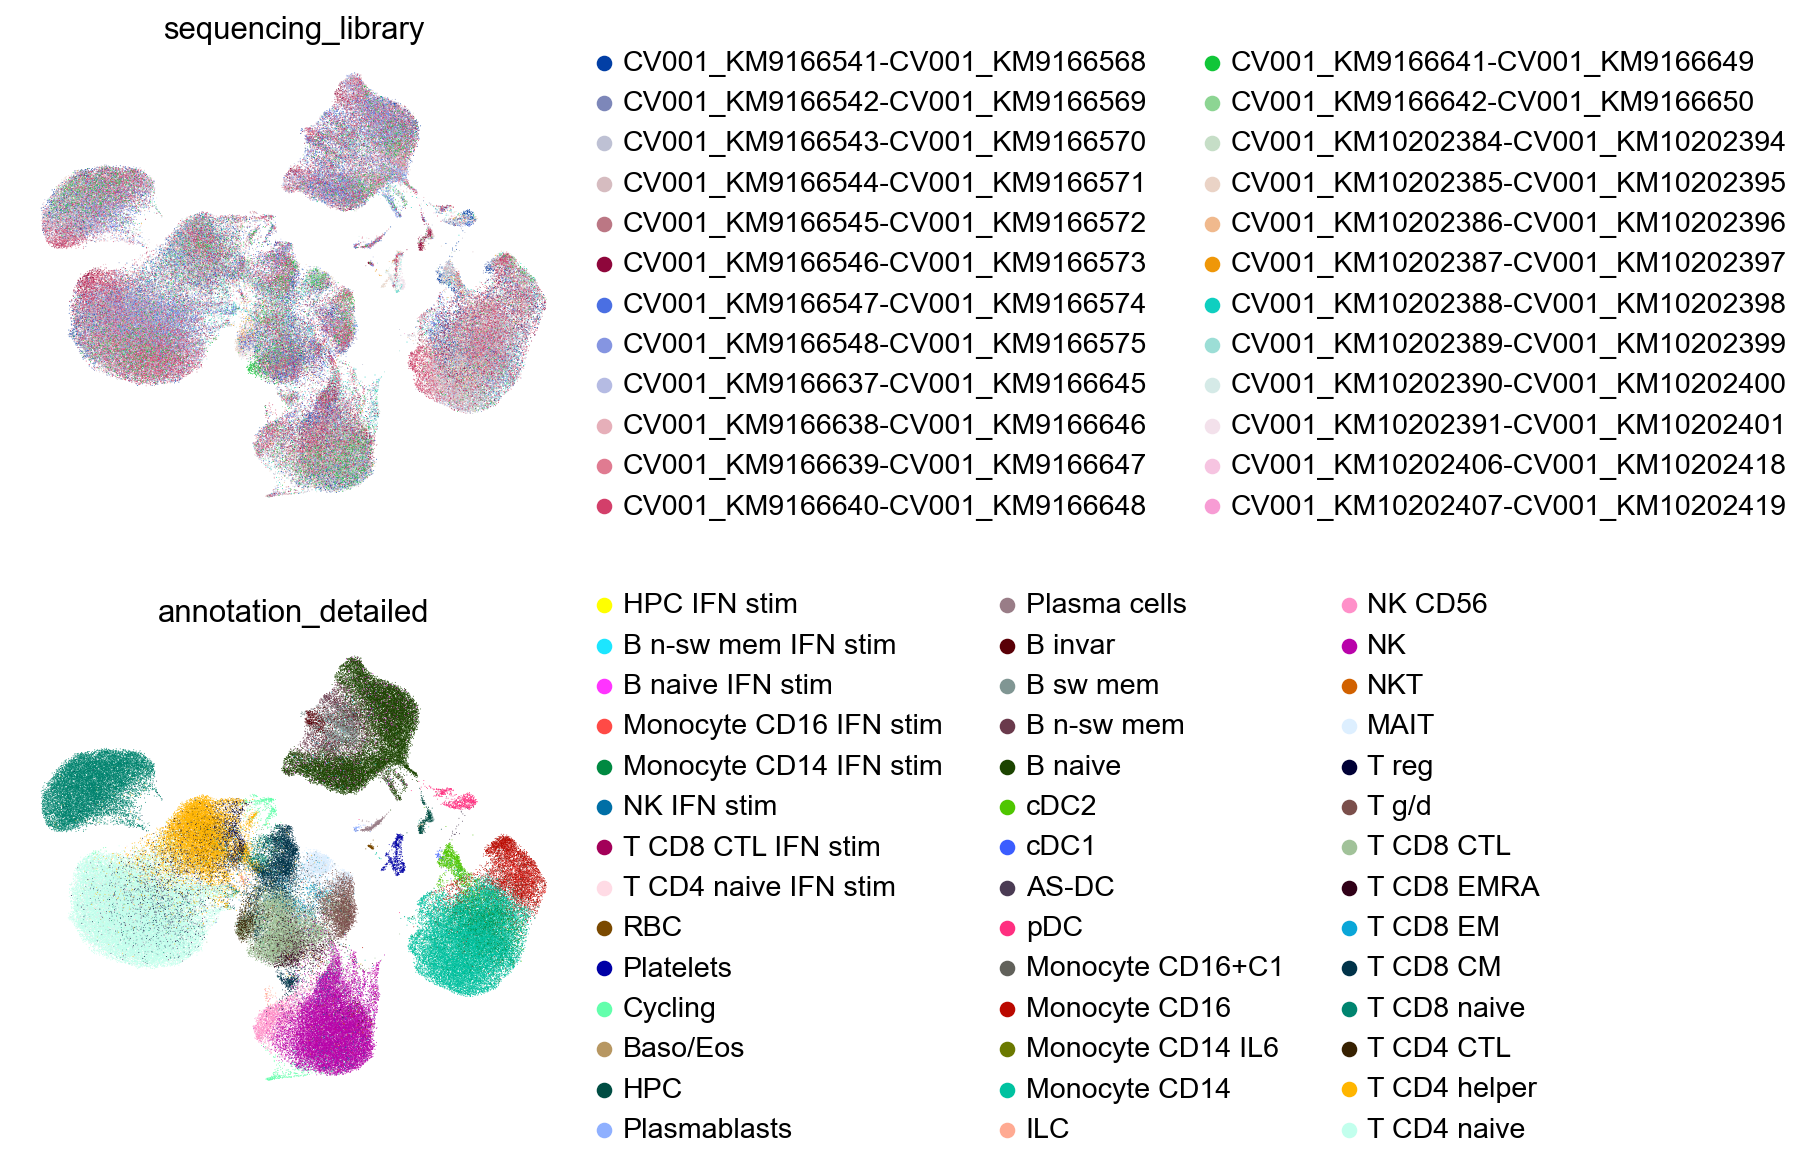

In [21]:
sc.pl.umap(
    adata_ref_new,
    color=["sequencing_library", "annotation_detailed"],
    frameon=False,
    ncols=1,
)

### Update with query

Question: Do you cluster your query data before entering it into the scanvi model?

In [22]:
dir_path_scan = "/Volumes/LaCie/data_lake/Mairi_example/processed_files/scanvi/models/"
vae_ref_scanvi.save(dir_path_scan, overwrite=True)

In [23]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(adata_query, dir_path_scan)

INFO     File /Volumes/LaCie/data_lake/Mairi_example/processed_files/scanvi/models/model.pt already downloaded     
INFO     Found 79.08333333333334% reference vars in query data.                                                    


/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:202: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  warnings.warn(


In [24]:
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query,
    dir_path_scan,
)

INFO     File /Volumes/LaCie/data_lake/Mairi_example/processed_files/scanvi/models/model.pt already downloaded     


/Users/mairi.mcclean/mambaforge/envs/scanvi_local/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


KeyError: 'sequencing_library not found in adata.obs.'

In [ ]:
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

In [ ]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

In [ ]:
df = adata_query.obs.groupby(["celltype", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

### Analyze reference and query

In [ ]:
adata_full = adata_query.concatenate(adata_ref)

In [ ]:
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)

In [ ]:
full_predictions = vae_q.predict(adata_full)
print(f"Acc: {np.mean(full_predictions == adata_full.obs.celltype)}")

adata_full.obs["predictions"] = full_predictions

In [ ]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

In [ ]:
sc.pl.umap(
    adata_full,
    color=["tech", "celltype"],
    frameon=False,
    ncols=1,
)

In [ ]:
ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["predictions"],
    frameon=False,
    title="Query predictions",
    ax=ax,
    alpha=0.7,
)

ax = sc.pl.umap(
    adata_full,
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[: adata_query.n_obs],
    color=["celltype"],
    frameon=False,
    title="Query observed cell types",
    ax=ax,
    alpha=0.7,
)